In [1]:
import skimage
from skimage.filters import rank, threshold_otsu, sobel_v
from skimage.morphology import disk, remove_small_objects
from skimage import transform
from skimage.morphology import skeletonize
from skimage.feature import register_translation
from skimage.registration import phase_cross_correlation
from skimage.transform import AffineTransform
import skimage.io as io
from skimage.util import img_as_uint
import random

from scipy import ndimage
import numpy as np

import time
import math
import logging
import os
import logging
import tifffile as tf
import tkinter as tk
import tkinter.filedialog as dia

from importlib import reload

In [2]:
from importlib import reload

import skimage
import numpy as np
from scipy import ndimage

import matplotlib.pyplot as plt

from byc import utilities, files, process, constants, rotation

for mod in [utilities, files, process, constants, rotation]:
    reload(mod)

In [5]:
image_path = files.select_file('choose image')

In [6]:
print(image_path)

C:/Users/John Cooper/Projects/byc/data/20200904_byc/input/Pos0/img_000000000_Brightfield_000.tif


In [7]:
image = skimage.io.imread(image_path)

### Segment vertical edges

In [8]:
r = rotation.ImageRotation(image, compute=True)

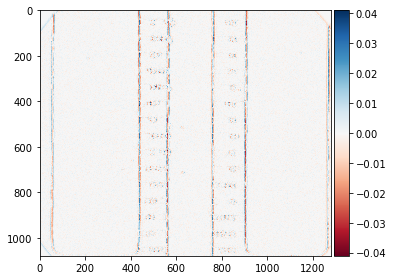

In [9]:
skimage.io.imshow(r.vertical_edges_img)

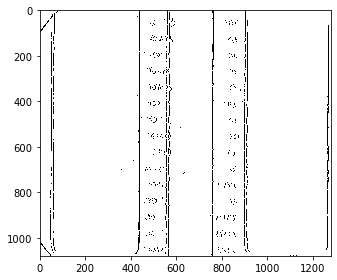

In [10]:
skimage.io.imshow(r.otsu_vertical_edges_img)

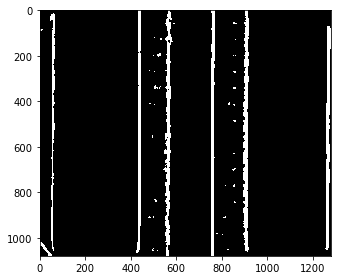

In [11]:
skimage.io.imshow(r.rank_mean_vertical_edges_img)

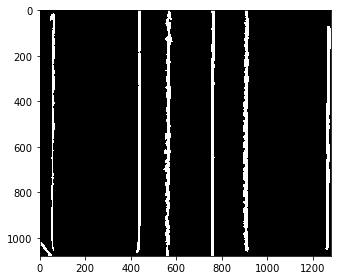

In [12]:
skimage.io.imshow(r.clean_vertical_edges_img)

C:\.byc\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


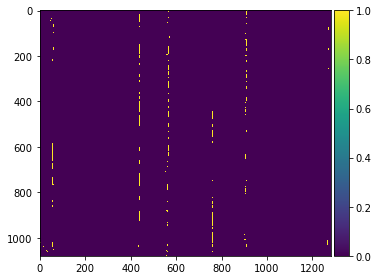

In [13]:
skimage.io.imshow(r.skeletons)

### Hough transform with skeletonized vertical edges

Rotational offset = 0.217 degrees


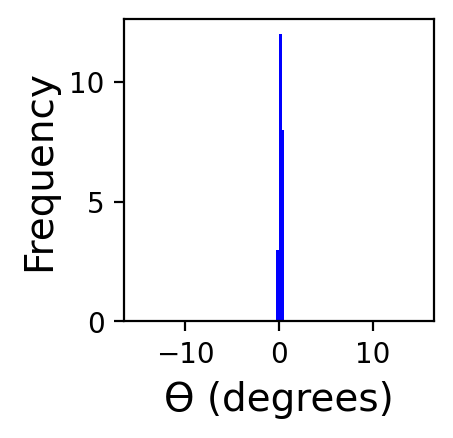

In [14]:
fig = plt.figure(figsize=(2, 2))
fig.set_dpi(200)
ax = plt.axes()
ax.hist(r.angles*57.2958, bins=100, range=(-15, 15),
        color='blue')

ax.set_ylabel(('Frequency'), fontsize=14)
ax.set_xlabel(('\u03F4 (degrees)'), fontsize=14)
print(f'Rotational offset = {str(r.offset)[0:5]} degrees')

### Rotated and raw image

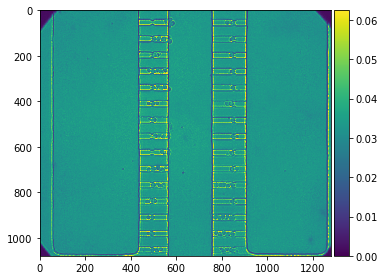

In [15]:
skimage.io.imshow(r.rotated_image)

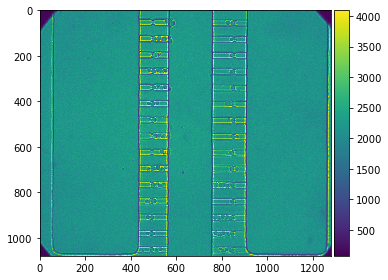

In [16]:
skimage.io.imshow(r.image)

### How to use alignment2

In [3]:
import os
import re

import tifffile

from byc import process, registration, constants

In [4]:
path = r"C:\Users\John Cooper\Projects\byc\data\20200904_byc\input"

In [5]:
byc_image_set = process.bycImageSet(input_dir_path=path)

In [19]:
fov_index = 0
channels = byc_image_set.fov_channels_dict(fov_index, byc_image_set.fov_dir_paths_dict)
# Find a good rotational offset and rotate images in each channel
# stack by that rotational offset
median_offset = process.get_median_rotational_offset(channels['Brightfield'])
rotated_channels = process.rotate_channels(channels, median_offset)
# Find translational offsets
# Registration typicall works better when I 
# use an image later in the stack for
base_image_index = int(len(rotated_channels['Brightfield'])/2)
base_image = rotated_channels['Brightfield'][base_image_index]
# Calculate the tranlsational registration offsets
offsets = registration.determine_offsets(base_image, rotated_channels['Brightfield'])
# translated_channels = process.translate_channels(rotated_channels, offsets)

Determining rotation offset for sample frame 1 of 3
Found rotational offset of 0.0802 degrees
Determining rotation offset for sample frame 2 of 3
Found rotational offset of 0.1031 degrees
Determining rotation offset for sample frame 3 of 3
Found rotational offset of 0.0917 degrees
Determining registation offset for frame 1 of 131
Offset Y=9.8 and X=-40.6
Determining registation offset for frame 2 of 131
Offset Y=-27.9 and X=-35.7
Determining registation offset for frame 3 of 131
Offset Y=-20.95 and X=-30.35
Determining registation offset for frame 4 of 131
Offset Y=-19.25 and X=-24.9
Determining registation offset for frame 5 of 131
Offset Y=-14.2 and X=-19.25
Determining registation offset for frame 6 of 131
Offset Y=-20.9 and X=-14.45
Determining registation offset for frame 7 of 131
Offset Y=-11.55 and X=-12.35
Determining registation offset for frame 8 of 131
Offset Y=-11.15 and X=-9.95
Determining registation offset for frame 9 of 131
Offset Y=-10.15 and X=-8.35
Determining regist

Offset Y=-3.75 and X=0.25
Determining registation offset for frame 105 of 131
Offset Y=1.4 and X=-2.75
Determining registation offset for frame 106 of 131
Offset Y=0.2 and X=-2.35
Determining registation offset for frame 107 of 131
Offset Y=1.85 and X=-3.05
Determining registation offset for frame 108 of 131
Offset Y=4.4 and X=-1.8
Determining registation offset for frame 109 of 131
Offset Y=0.9 and X=-2.45
Determining registation offset for frame 110 of 131
Offset Y=2.3 and X=-0.6
Determining registation offset for frame 111 of 131
Offset Y=8.85 and X=-2.1
Determining registation offset for frame 112 of 131
Offset Y=-0.25 and X=-0.4
Determining registation offset for frame 113 of 131
Offset Y=4.8 and X=-2.2
Determining registation offset for frame 114 of 131
Offset Y=-0.25 and X=-1.65
Determining registation offset for frame 115 of 131
Offset Y=5.4 and X=-1.75
Determining registation offset for frame 116 of 131
Offset Y=-4.2 and X=-2.2
Determining registation offset for frame 117 of 1

In [7]:
channels.keys()

dict_keys(['Brightfield', 'RFP', 'YFP'])

In [61]:
translated_channels = process.translate_channels(channels, filts)
write_output = True
# Save each translated channel stack
fov_dir_path = byc_image_set.fov_dir_paths_dict[fov_index]
# Find the expt date file naming purposes
date_pattern = constants.patterns.date
expt_date = re.search(date_pattern, fov_dir_path).group()
if write_output:

    fov_str = str(fov_index).zfill(2)
    basefilename = f'{expt_date}_byc_xy{fov_str}'
    base_writepath = os.path.join(byc_image_set.output_dir_path, basefilename)

    for channel_name, stack in translated_channels.items():
        print(f'Saving {channel_name} stack...')
        
        if channel_name == 'Brightfield':
            stack = skimage.util.img_as_uint(skimage.io.concatenate_images(stack))
            writepath = f'{base_writepath}_bf_stack_filter_aligned.tif'
            tifffile.imsave(writepath, stack)
        else:
            writepath = f'{base_writepath}_{channel_name.lower()}_stack.tif'


Saving Brightfield stack...
Saving RFP stack...
Saving YFP stack...


In [27]:
# Save unaligned stack
write_output = True
# Save each translated channel stack
fov_dir_path = byc_image_set.fov_dir_paths_dict[fov_index]
# Find the expt date file naming purposes
date_pattern = constants.patterns.date
expt_date = re.search(date_pattern, fov_dir_path).group()
if write_output:

    fov_str = str(fov_index).zfill(2)
    basefilename = f'{expt_date}_byc_xy{fov_str}'
    base_writepath = os.path.join(byc_image_set.output_dir_path, basefilename)

    for channel_name, stack in channels.items():
        print(f'Saving {channel_name} stack...')
        stack = skimage.util.img_as_uint(skimage.io.concatenate_images(stack))
        if channel_name == 'Brightfield':
            writepath = f'{base_writepath}_bf_stack.tif'
            tifffile.imsave(writepath, stack)        

Saving Brightfield stack...
Saving RFP stack...
Saving YFP stack...


In [29]:
from importlib import reload

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'

from byc import process, registration, constants, trace_tools, fitting_tools
for mod in [process, registration, constants, trace_tools, fitting_tools]:
    reload(mod)

In [59]:
def filter_vertical_outliers(offsets, kernsize=5, cutoff_factor=3, **kwargs):
    """
    Take offsets, a list of tuples with shape:
    
    [(Y_offset, X_offsets),
    ...]
    
    Calculate the residuals of computed offsets from
    a sliding median window of width kernsize. Then
    filter offsets whose residual is more than 
    cutoff_factor*std. deviation of all offset
    residuals away from the median.
    
    Return a filtered offsets list of the same shape
    as the one passed.
    
    Pass a base_writepath kwarg if you want to save
    an offsets_df
    """
    base_writepath = kwargs.get('base_writepath', None)
    
    Y_offsets = np.array([offset[0] for offset in offsets])
    X_offsets = np.array([offset[1] for offset in offsets])

    offsets_df = pd.DataFrame({'y_offsets': Y_offsets,
                               'x_offsets': X_offsets})
    
    offsets_df = trace_tools.median_filter(offsets_df,
                                       'y_offsets',
                                       kernel_size=kernsize
                                       , name_with_kernel=True)

    offsets_df = trace_tools.median_filter(offsets_df,
                                           'x_offsets',
                                           kernel_size=kernsize,
                                           name_with_kernel=True)
    
    offsets_df.loc[:, 'y_resid'] = offsets_df.y_offsets - offsets_df.y_offsets_medfilt_5
    offsets_df.loc[:, 'x_resid'] = offsets_df.x_offsets - offsets_df.x_offsets_medfilt_5
    # Find vertical offset outliers
    CI_width = cutoff_factor*offsets_df.y_resid.std()
    upper_thresh = offsets_df.y_resid.median() + CI_width
    lower_thresh = offsets_df.y_resid.median() -CI_width

    offsets_df.loc[:, 'vert_outlier'] = 0
    offsets_df.loc[offsets_df.y_resid > upper_thresh, 'vert_outlier'] = 1
    offsets_df.loc[offsets_df.y_resid < lower_thresh, 'vert_outlier'] = 1
    
    if base_writepath:
        offsets_df.to_csv(''.join([base_writepath, '_registration_offsets.csv']))
    
    filtered_offsets = []
    for i, row in enumerate([offsets_df.loc[ind, :] for ind in offsets_df.index]):
        ib = i
        if row.vert_outlier == 1:
            y_offset = None
            while y_offset == None:
                ib += 1
                next_row = offsets_df.loc[ib, :] 
                if next_row.vert_outlier == 0:
                    y_offset = next_row.y_offsets
                else:
                    y_offset = None

            filtered_offset = (y_offset, row.x_offsets)
        else:
            filtered_offset = (row.y_offsets, row.x_offsets)

        filtered_offsets.append(filtered_offset)                    
        
    return filtered_offsets

In [60]:
filts = filter_vertical_outliers(offsets)

Using next offset -27.9


In [56]:
filtered_offsets

[(-27.9, -40.6),
 (-27.9, -35.7),
 (-20.95, -30.35),
 (-19.25, -24.9),
 (-14.2, -19.25),
 (-20.9, -14.45),
 (-11.55, -12.35),
 (-11.15, -9.95),
 (-10.15, -8.35),
 (-8.5, -6.55),
 (-10.1, -7.05),
 (-13.0, -4.55),
 (-16.1, -1.85),
 (-11.95, -1.7),
 (-11.6, -1.55),
 (-7.15, 0.7),
 (-7.05, 1.3),
 (-9.95, 1.6),
 (-7.2, 3.2),
 (-9.2, 2.4),
 (-7.7, 2.8),
 (-5.85, 4.05),
 (-9.05, 3.05),
 (-5.7, 5.1),
 (-11.1, 4.05),
 (-8.1, 4.95),
 (-6.95, 4.9),
 (-6.65, 4.8),
 (-7.1, 4.35),
 (-6.8, 4.25),
 (-5.35, 3.8),
 (-9.85, 4.0),
 (-5.7, 4.85),
 (-3.65, 5.25),
 (-3.95, 4.3),
 (-5.15, 4.35),
 (-3.7, 2.7),
 (-2.9, 3.5),
 (-9.0, 4.45),
 (-1.4, 3.6),
 (-1.5, 3.7),
 (-1.5, 3.25),
 (-4.85, 3.2),
 (-0.05, 2.75),
 (1.9, 2.35),
 (-2.5, 3.0),
 (2.05, 3.3),
 (2.2, 2.95),
 (1.7, 2.85),
 (-1.1, 2.95),
 (0.35, 2.6),
 (0.8, 0.8),
 (-3.45, 1.3),
 (3.35, 2.85),
 (2.15, 2.25),
 (-0.9, 1.45),
 (-1.95, 2.75),
 (-1.25, 2.25),
 (-1.85, 2.3),
 (-2.95, 1.65),
 (-3.65, 2.1),
 (-2.75, 1.4),
 (0.6, 0.3),
 (-6.25, 0.35),
 (-1.1, 0.

In [55]:
filtered_offsets = []
for i, row in enumerate([offsets_df.loc[ind, :] for ind in offsets_df.index]):
    ib = i
    if row.vert_outlier == 1:
        y_offset = None
        while y_offset == None:
            ib += 1
            next_row = offsets_df.loc[ib, :] 
            if next_row.vert_outlier == 0:
                y_offset = next_row.y_offsets
                print(f'Using next offset {y_offset}')
            else:
                y_offset = None
                    
        filtered_offset = (y_offset, row.x_offsets)
    else:
        filtered_offset = (row.y_offsets, row.x_offsets)

    filtered_offsets.append(filtered_offset)                    

Using next offset -27.9


In [22]:
kernsize = 5

offsets_df = trace_tools.median_filter(offsets_df,
                                       'y_offsets',
                                       kernel_size=kernsize
                                       , name_with_kernel=True)

offsets_df = trace_tools.median_filter(offsets_df,
                                       'x_offsets',
                                       kernel_size=kernsize,
                                       name_with_kernel=True)

offsets_df.loc[:, 'y_resid'] = offsets_df.y_offsets - offsets_df.y_offsets_medfilt_5
offsets_df.loc[:, 'x_resid'] = offsets_df.x_offsets - offsets_df.x_offsets_medfilt_5
# Find vertical offset outliers
CI_width = 3*offsets_df.y_resid.std()
upper_thresh = offsets_df.y_resid.median() + CI_width
lower_thresh = offsets_df.y_resid.median() -CI_width

offsets_df.loc[:, 'vert_outlier'] = 0
offsets_df.loc[offsets_df.y_resid > upper_thresh, 'vert_outlier'] = 1
offsets_df.loc[offsets_df.y_resid < lower_thresh, 'vert_outlier'] = 1
# Find horizontal offets outliers
CI_width = 3*offsets_df.x_resid.std()
upper_thresh = offsets_df.x_resid.median() + CI_width
lower_thresh = offsets_df.x_resid.median() -CI_width

offsets_df.loc[:, 'horiz_outlier'] = 0
offsets_df.loc[offsets_df.x_resid > upper_thresh, 'horiz_outlier'] = 1
offsets_df.loc[offsets_df.x_resid < lower_thresh, 'horiz_outlier'] = 1

offsets_df.to_csv(''.join([base_writepath, '_registration_offsets.csv']))

In [428]:
gaus = fitting_tools.gaussian

y, x = np.histogram(offsets_df.y_resid, bins=30)
x = x[1:]
mean = offsets_df.y_resid.mean()
sigma = offsets_df.y_resid.std()

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

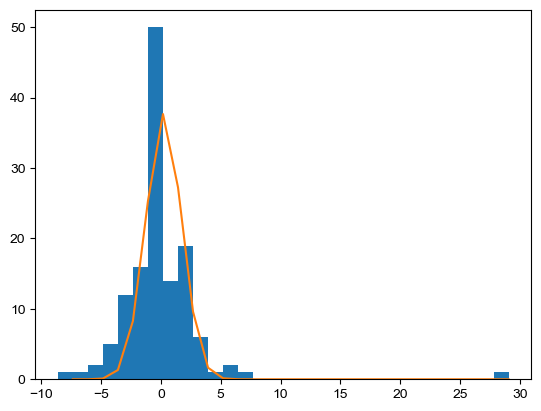

In [414]:
plt.hist(offsets_df.y_resid, bins=30);
plt.plot(x, gaus(x, *popt))

#### Vertical offsets

In [23]:
cmap = plt.get_cmap('spring')

In [24]:
def plot_vert_outliers(offsets_df, lineax, histax):
    
    for i, row in enumerate([offsets_df.loc[ind, :] for ind in offsets_df.index]):
        
        if row['vert_outlier'] == 1:

            facecolors = 'none'
            edgecolors = cmap(i*200)

            lineax.scatter(i+1, row.y_offsets,
                           facecolors=facecolors,
                           edgecolors=edgecolors)

            histax.scatter(row.y_resid-0.7, 0.5,
                           facecolors=facecolors,
                           edgecolors=edgecolors)
            
def plot_horiz_outliers(offsets_df, lineax, histax):
    
    for i, row in enumerate([offsets_df.loc[ind, :] for ind in offsets_df.index]):
        
        if row['horiz_outlier'] == 1:

            facecolors = 'none'
            edgecolors = cmap(i*200)

            lineax.scatter(i+1, row.x_offsets,
                        facecolors=facecolors,
                        edgecolors=edgecolors)

            histax.scatter(row.x_resid, 0.5,
                            facecolors=facecolors,
                            edgecolors=edgecolors)

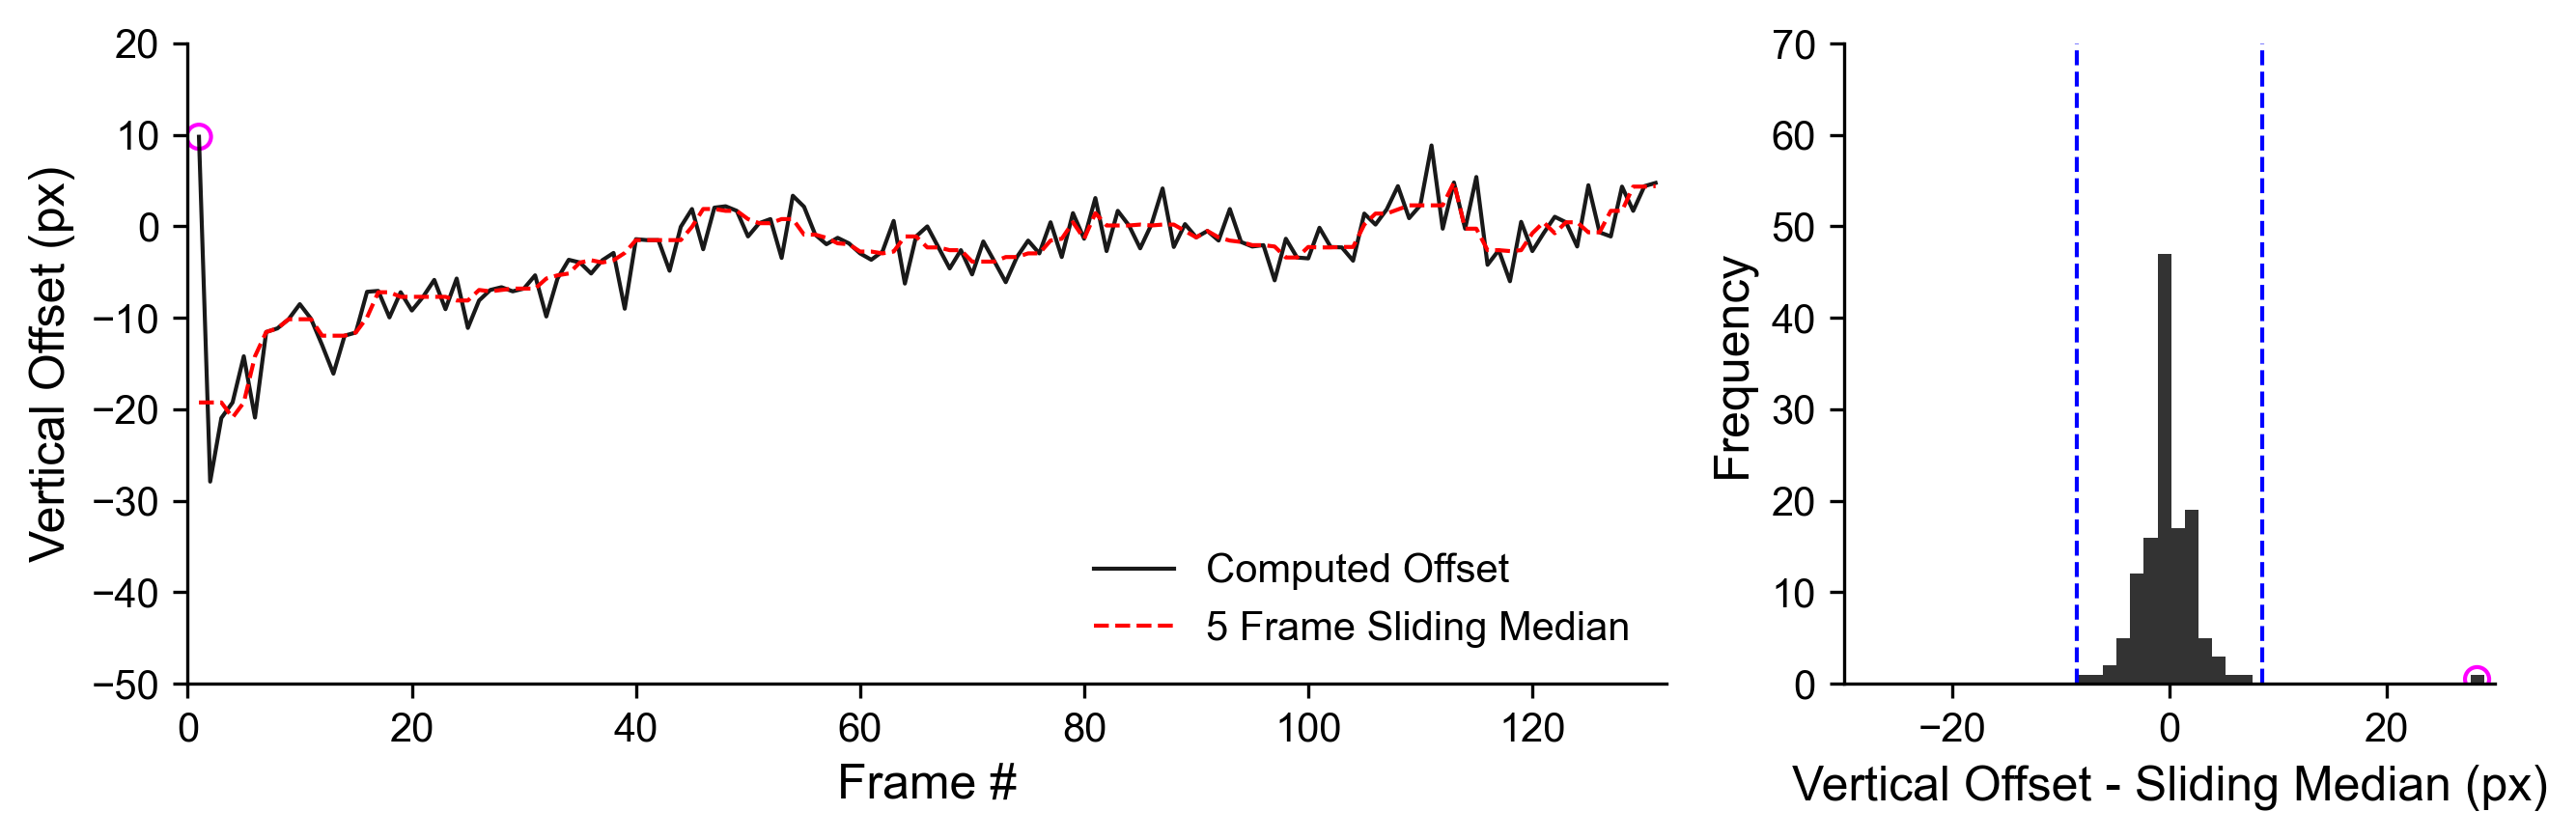

In [62]:
CI_width = 2.5*offsets_df.y_resid.std()
upper_thresh = offsets_df.y_resid.median() + CI_width
lower_thresh = offsets_df.y_resid.median() - CI_width

y = offsets_df.y_offsets
y_filt = offsets_df.y_offsets_medfilt_5

resids = offsets_df.y_resid

x = np.arange(1, len(y)+1, 1)
figsize = (9, 3)
width = figsize[0]
height = figsize[1]
fontsize = 12

fig = plt.figure(figsize=figsize, tight_layout=True)
fig.set_dpi(300)

grid = plt.GridSpec(figsize[1], figsize[0])

xlim = (0, np.max(x)+1)
# ylim = (-50, 20)
xlim_hist = (-30, 30)
ylim_hist = (0, 70)
ax1 = fig.add_subplot(grid[:, 0:int(width/3)*2])
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_ylabel('Vertical Offset (px)', fontsize=fontsize)
ax1.set_xlabel('Frame #', fontsize=fontsize)

ax1.plot(x, y,
         color='black',
         linewidth=1,
         alpha=0.9)
ax1.plot(x, y_filt,
         color='red',
         linestyle='--',
         linewidth=1)

# Line plot legend
custom_lines = [Line2D([0], [0],
                       lw=1,
                       linestyle='-',
                       color='black',
                       alpha=0.9),
                Line2D([0], [0],
                       lw=1,
                       linestyle='--',
                       color='red')]

ax1.legend(custom_lines, ['Computed Offset', f'{kernsize} Frame Sliding Median'],
           frameon=False,
           loc='lower right')

# Histogram part
ax2 = fig.add_subplot(grid[:, int(width/3)*2:])
ax2.set_ylabel('Frequency', fontsize=fontsize)
ax2.set_xlabel('Vertical Offset - Sliding Median (px)', fontsize=fontsize)
ax2.set_xlim(xlim_hist)
ax2.set_ylim(ylim_hist)
ax2.hist(resids,
         bins=30,
         color='black',
         alpha=0.8)

for x in [lower_thresh, upper_thresh]:
    ax2.axvline(x, color='blue',
                linestyle='--',
                linewidth=1)
    

# Plot outliers
plot_vert_outliers(offsets_df, ax1, ax2)

hidden_spines = ['top', 'right']

for ax in [ax1, ax2]:
    for spine in [ax.spines[name] for name in hidden_spines]:
            spine.set_visible(False)

#### Horizontal offsets

In [461]:
ax1.legend?

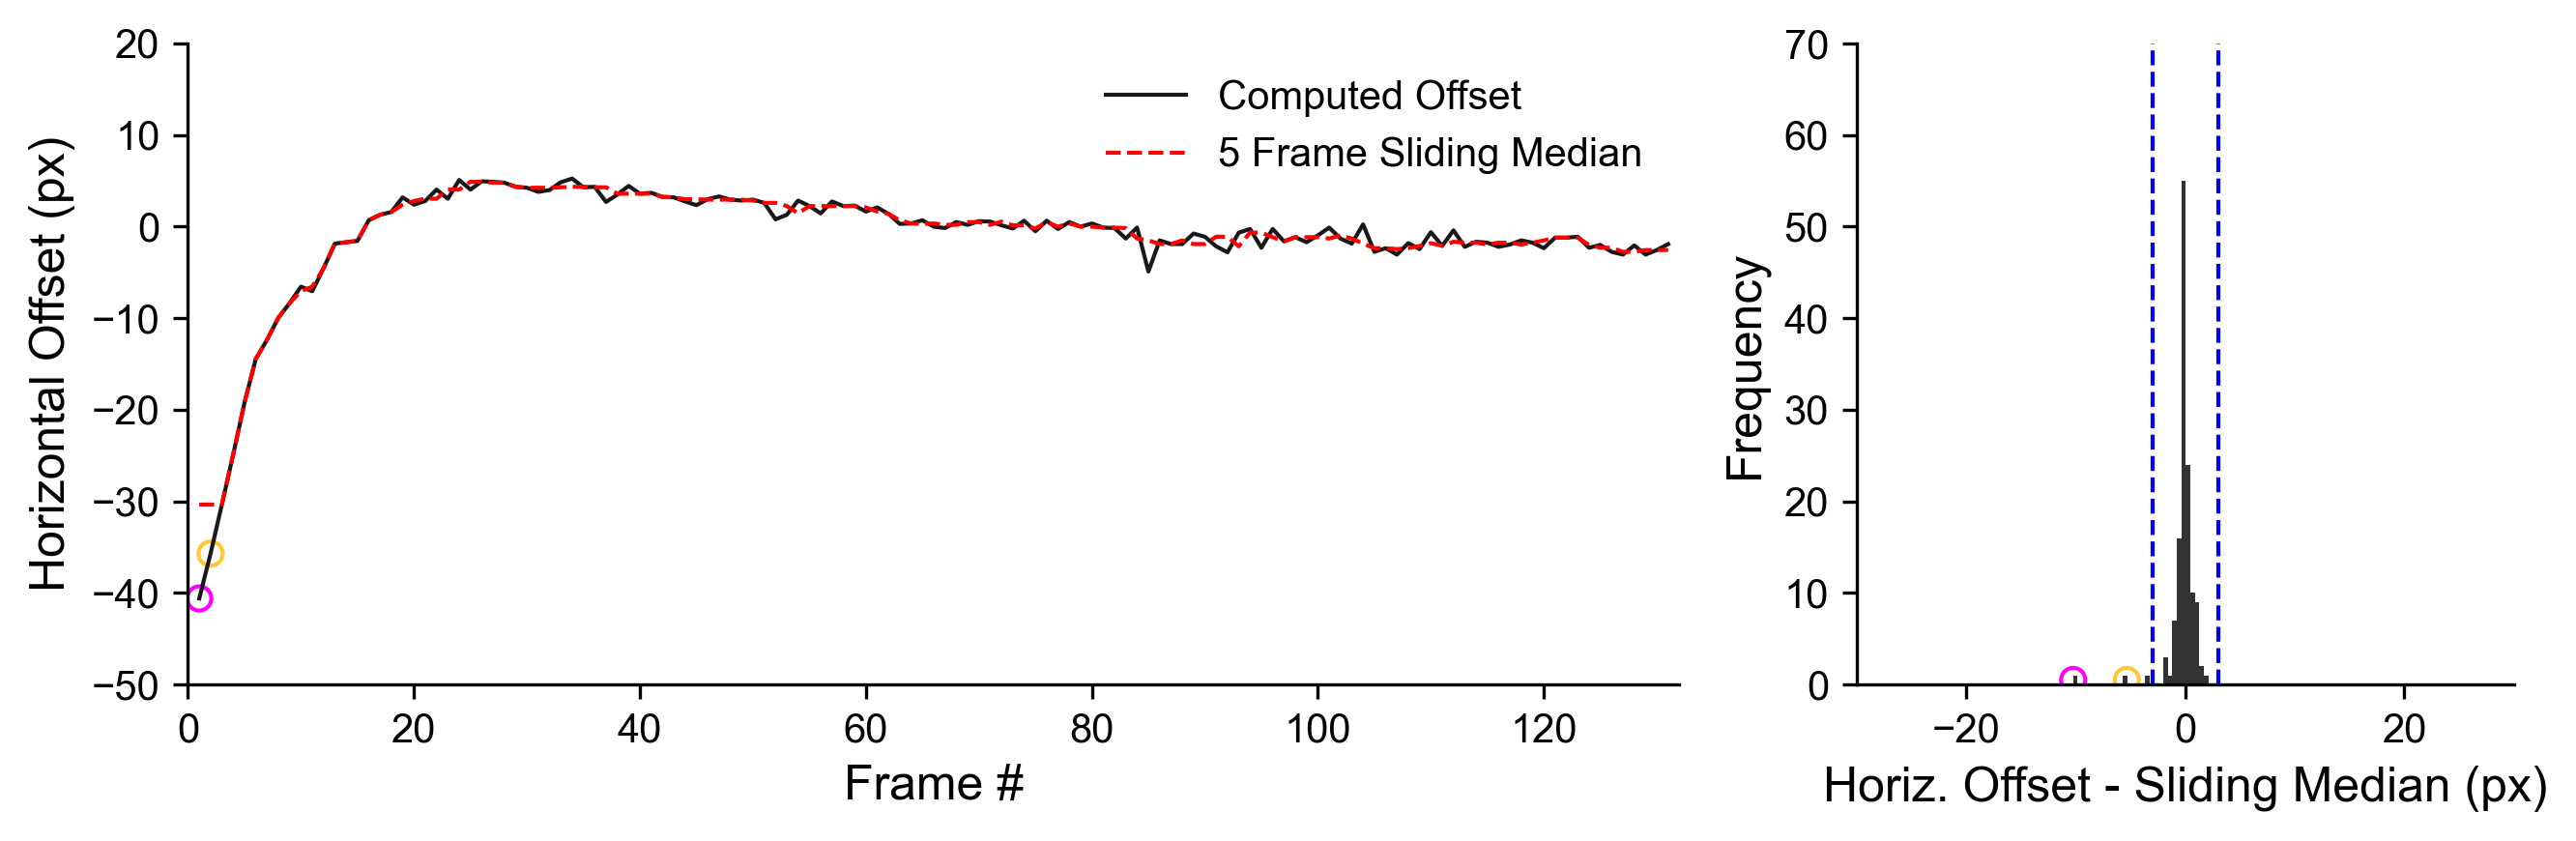

In [26]:
CI_width = offsets_df.x_resid.std()*2.5
lower_thresh = offsets_df.x_resid.median() - CI_width
upper_thresh = offsets_df.x_resid.median() + CI_width

y = offsets_df.x_offsets
y_filt = offsets_df.x_offsets_medfilt_5

resids = offsets_df.x_resid

x = np.arange(1, len(y)+1, 1)
figsize = (9, 3)
width = figsize[0]
height = figsize[1]
fontsize = 12

fig = plt.figure(figsize=figsize, tight_layout=True)
fig.set_dpi(300)

grid = plt.GridSpec(figsize[1], figsize[0])

# Line plot
ax1 = fig.add_subplot(grid[:, 0:int(width/3)*2])
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_ylabel('Horizontal Offset (px)', fontsize=fontsize)
ax1.set_xlabel('Frame #', fontsize=fontsize)

ax1.plot(x, y,
         color='black',
         linewidth=1,
         alpha=0.9)
ax1.plot(x, y_filt,
         color='red',
         linestyle='--',
         linewidth=1)

# Line plot legend
custom_lines = [Line2D([0], [0],
                       lw=1,
                       linestyle='-',
                       color='black',
                       alpha=0.9),
                Line2D([0], [0],
                       lw=1,
                       linestyle='--',
                       color='red')]

ax1.legend(custom_lines, ['Computed Offset', f'{kernsize} Frame Sliding Median'],
           frameon=False)

# Histogram
ax2 = fig.add_subplot(grid[:, int(width/3)*2:])
ax2.set_ylabel('Frequency', fontsize=fontsize)
ax2.set_xlim(xlim_hist)
ax2.set_ylim(ylim_hist)
ax2.set_xlabel('Horiz. Offset - Sliding Median (px)', fontsize=fontsize)
ax2.hist(resids,
         bins=30,
         color='black',
         alpha=0.8)

for x in [lower_thresh, upper_thresh]:
    ax2.axvline(x, color='blue',
                linestyle='--',
                linewidth=1)    
# Plot outliers
plot_horiz_outliers(offsets_df, ax1, ax2)

hidden_spines = ['top', 'right']

for ax in [ax1, ax2]:
    for spine in [ax.spines[name] for name in hidden_spines]:
            spine.set_visible(False)

(array([ 1.,  0.,  0.,  1.,  0.,  1.,  4., 28., 86., 10.]),
 array([-10.35 ,  -9.095,  -7.84 ,  -6.585,  -5.33 ,  -4.075,  -2.82 ,
         -1.565,  -0.31 ,   0.945,   2.2  ]),
 <a list of 10 Patch objects>)

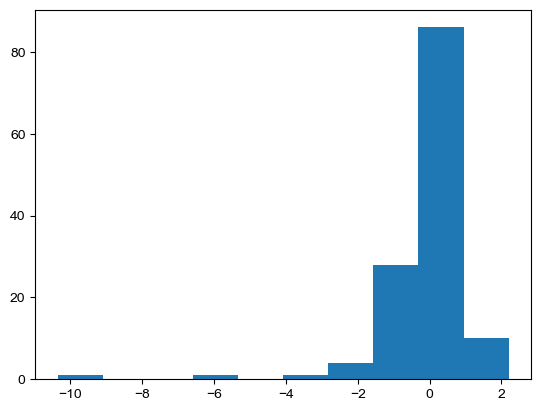

In [232]:
plt.hist(offsets_df.x_resid)

In [231]:
offsets_df

,y_offsets,x_offsets,y_offsets_medfilt_5,x_offsets_medfilt_5,y_resid,x_resid
0,9.75,-40.65,-19.30,-30.30,29.05,-10.35
1,-27.90,-35.70,-19.30,-30.30,-8.60,-5.40
2,-21.00,-30.30,-19.30,-30.30,-1.70,0.00
3,-19.30,-24.90,-20.90,-24.90,1.60,0.00
4,-14.20,-19.25,-19.30,-19.25,5.10,0.00
...,...,...,...,...,...,...
126,-1.20,-3.05,1.70,-2.75,-2.90,-0.30
127,4.35,-2.00,1.70,-2.75,2.65,0.75
128,1.70,-3.05,4.35,-2.55,-2.65,-0.50
129,4.40,-2.55,4.35,-2.55,0.05,0.00


In [230]:
offsets_df.y_resid.argmin()

1

In [ ]:
y = offsets_df.y_offsets
y_filt = offsets_df.y_offsets_medfilt_5

x = np.arange(1, len(y)+1, 1)
figsize = (6, 6)
width = figsize[0]
height = figsize[1]
fontsize = 12

fig = plt.figure(figsize=figsize, tight_layout=True)
fig.set_dpi(300)

grid = plt.GridSpec(figsize[0], figsize[1], wspace=0.4, hspace=1)

xlim = (0, np.max(x)+1)
ylim = (-30, 15)
ax1 = fig.add_subplot(grid[0:int(height/2), :])
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_ylabel('Vertical Offset (px)', fontsize=fontsize)
ax1.set_xlabel('Frame #', fontsize=fontsize)

ax1.plot(x, y,
         color='black',
         linewidth=1,
         alpha=0.8)
ax1.plot(x, y_filt,
         color='red',
         linestyle='--',
         linewidth=1)

# Histogram part
ax2 = fig.add_subplot(grid[int(height/2):, 0:int(width/2)])
ax2.set_ylabel('Frequency', fontsize=fontsize)
ax2.set_xlabel('Vertical Offset - Sliding Median (px)', fontsize=fontsize)
ax2.hist(offsets_df.y_resid,
         bins=20,
         color='black',
         alpha=0.8)

hidden_spines = ['top', 'right']

for ax in [ax1, ax2]:
    for spine in [ax.spines[name] for name in hidden_spines]:
            spine.set_visible(False)

### Cropping 

In [1]:
import skimage
from skimage.filters import rank, threshold_otsu, sobel_v
from skimage.morphology import disk, remove_small_objects
from skimage import transform
from skimage.morphology import skeletonize
from skimage.feature import register_translation
from skimage.registration import phase_cross_correlation
from skimage.transform import AffineTransform
import skimage.io as io
from skimage.util import img_as_uint
import random

from scipy import ndimage
import numpy as np

import time
import math
import logging
import os
import logging
import tifffile as tf
import tkinter as tk
import tkinter.filedialog as dia

from importlib import reload

In [5]:
import os

import skimage
from skimage import io
import numpy as np
from scipy import ndimage

import matplotlib.pyplot as plt

from byc import utilities, files, process, constants, rotation

for mod in [utilities, files, process, constants, rotation]:
    reload(mod)

In [10]:
def main(return_image=False):

    fraction=0.5
    image_paths = files.select_files('choose images')
    writedir = os.path.join(os.path.dirname(image_paths[0]), 'cropped')
    if not os.path.exists(writedir):
        os.mkdir(writedir)

    for path in image_paths:

        image = skimage.io.imread(path)
        if len(image.shape) == 3:        
            print(f'Opened image with dimension {image.shape} at {path}')

            total_width = image.shape[2]
            crop_width = int(np.round(total_width*fraction))

            start = int(np.round((total_width - crop_width)/2))
            end = start + crop_width

            cropped_stack = image[:, :, start:end]
            writepath = path.replace(os.path.dirname(path), writedir)
            io.imsave(writepath, cropped_stack)

            print(f'Saved cropped image at {writepath}')

        elif len(image.shape) != 3:        
            print(f'Opened image with dimension {image.shape} at {path} ')
            print('Image array should have 3 dimensions')
            
    if return_image:
        return image
main()

Opened image with dimension (505, 1080, 640) at D:/johncooper/20210416_byc/output/cropped/20210416_byc_xy00_bf_stack.tif


<ipython-input-10-5194612bcd9e>:23: UserWarning: D:/johncooper/20210416_byc/output/cropped\cropped/20210416_byc_xy00_bf_stack.tif is a low contrast image
  io.imsave(writepath, cropped_stack)


Saved cropped image at D:/johncooper/20210416_byc/output/cropped\cropped/20210416_byc_xy00_bf_stack.tif


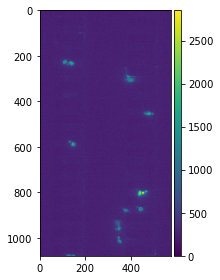

In [6]:
fraction=0.45
total_width = image.shape[2]
crop_width = int(np.round(total_width*0.45))

start = int(np.round((total_width - crop_width)/2))
end = start + crop_width

io.imshow(image[200][:, start:end])

cropped_stack = image[:, :, start:end]

In [21]:
io.imsave?

In [22]:
io.imsave( image_path.replace('.tif', '_cropped.tif'), cropped_stack)

<ipython-input-22-f40dbdcb15e0>:1: UserWarning: C:/Users/John Cooper/Projects/byc/data/20201127_byc/output/20201127_byc_xy00_bf_stack_cropped.tif is a low contrast image
  io.imsave( image_path.replace('.tif', '_cropped.tif'), cropped_stack)


# Auto-contrast stacks

In [23]:
import re
import os

import tifffile
import skimage
from skimage import io
import numpy as np

import matplotlib.pyplot as plt
import matplotlib


from skimage import data, img_as_float
from skimage import exposure

from byc import constants
from byc import plotting
plotting.set_styles(matplotlib, plt)

In [60]:
exposure.adjust_gamma?

In [72]:
np.std(avg_intensities)

3455.0537474902535

In [73]:
np.median(avg_intensities)

11908.5

In [79]:
plt.plot(gammas)

NameError: name 'gammas' is not defined

In [107]:
# def contrast_stack(readpath, writeoutput=True, **kwargs):
    
readpath = r"C:\Users\johnp\Dropbox\Projects\byc\data\20220211_byc\20220211_byc_JPC122_YFP-ODC(47)_BY4741\20220211_byc_xy05_bf_unaligned_stack.tif"
writepath = readpath.replace('.tif', '_contrasted.tif')

stack = io.imread(readpath)
# Find median intensity over all frames to determine how to calculate
# how much brightening to do
avg_intensities = np.array([np.median(img) for img in stack])
median_intensity = np.median(avg_intensities)

gammas = (avg_intensities/median_intensity)
contrasted_imgs = []
for gamma, img in zip(gammas, stack):
    if np.mean(img) < median - np.std(avg_intensities)*2:
        gamma = 0.45
    contrasted_img = exposure.adjust_gamma(img, gamma)
    contrasted_imgs.append(contrasted_img)

final_stack =  io.concatenate_images(contrasted_imgs)
io.imsave(writepath, final_stack)
print(f'Saved auto contrasted stack at {writepath}')

Saved auto contrasted stack at C:\Users\johnp\Dropbox\Projects\byc\data\20220211_byc\20220211_byc_JPC122_YFP-ODC(47)_BY4741\20220211_byc_xy05_bf_unaligned_stack_contrasted.tif


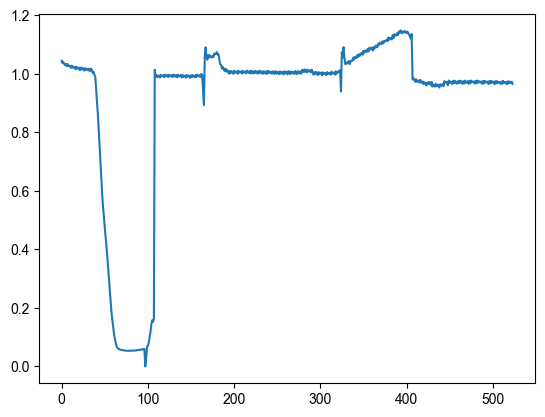

In [87]:
plt.plot(gamma

(0.0, 2.0)

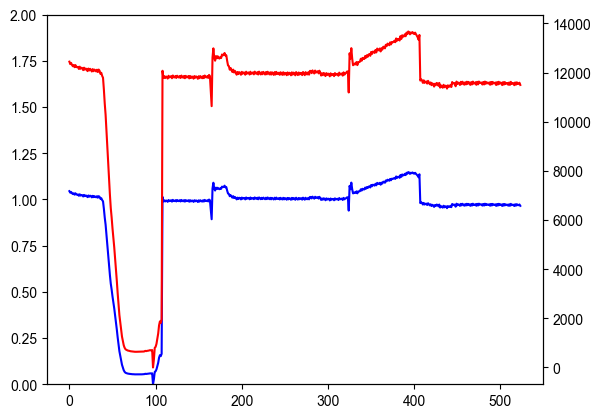

In [93]:
ax = plt.axes()
ax2 = ax.twinx()
ax.plot(gammas, color='blue')
ax2.plot(avg_intensities, color='red')

ax.set_ylim(0, 2)

In [78]:
path = r"C:\Users\johnp\Dropbox\Projects\byc\data\20220211_byc\20220211_byc_JPC122_YFP-ODC(47)_BY4741\20220211_byc_xy01_bf_stack.tif"
contrast_stack(path)

Saved auto contrasted stack at C:\Users\johnp\Dropbox\Projects\byc\data\20220211_byc\20220211_byc_JPC122_YFP-ODC(47)_BY4741\20220211_byc_xy01_bf_stack_contrasted.tif


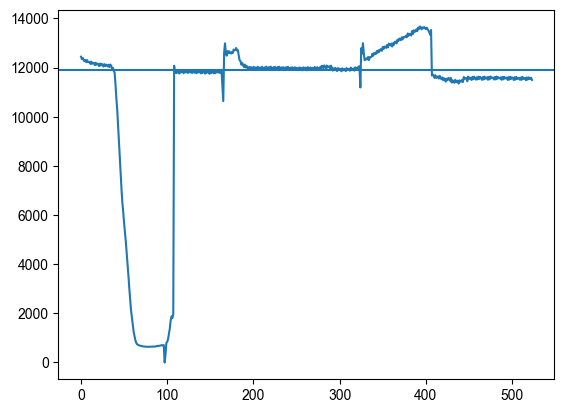

In [59]:


plt.plot(avg_intensity)
plt.axhline(median)

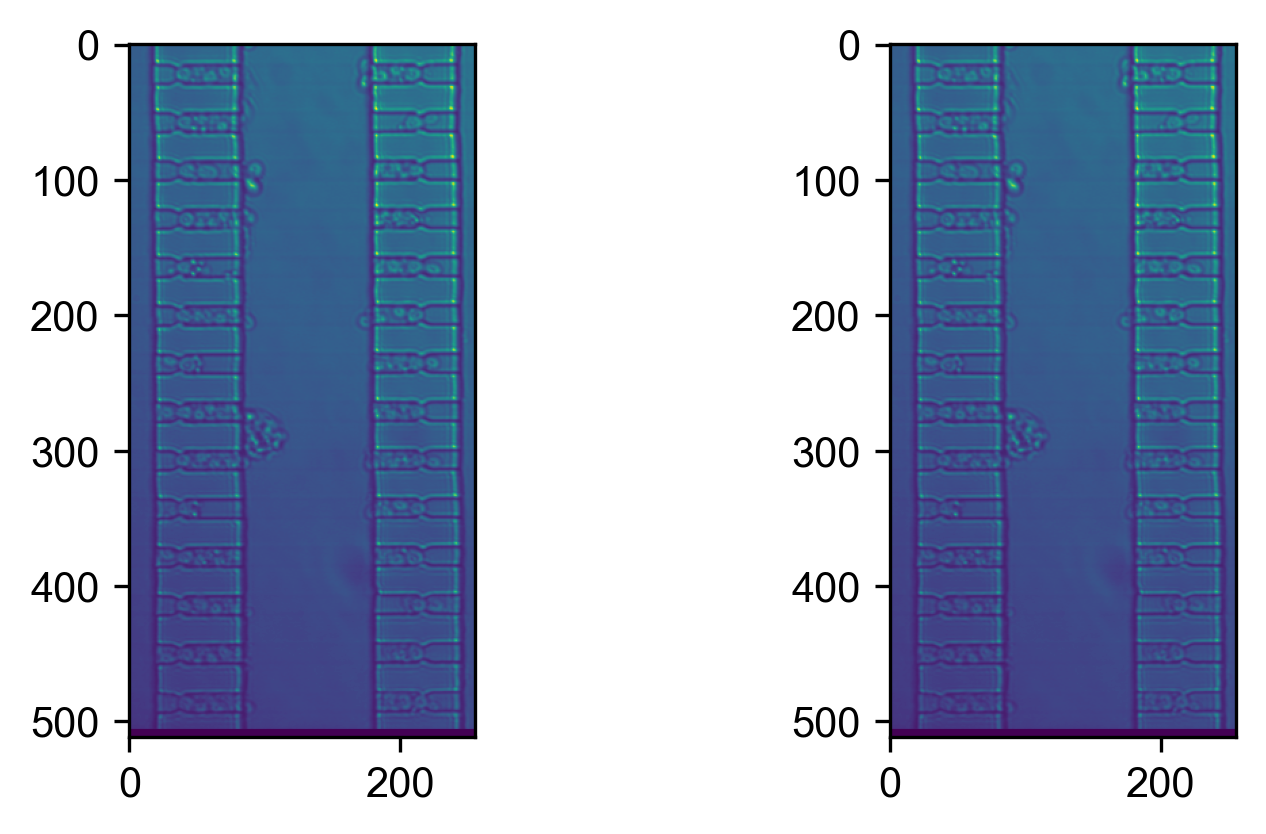

In [56]:
frame = 54
img = stack[frame]
# Gamma
gamma_corrected = exposure.adjust_gamma(img, 1)

# Logarithmic
logarithmic_corrected = exposure.adjust_gamma(img, 0.3)

corrected = gamma_corrected
fig = plt.figure(figsize=(6, 3))
fig.set_dpi(300)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(img)
ax2.imshow(corrected)